# Image classification in pytorch

# The MNIST dataset
- MNIST handwritten digits dataset:
    - Classification task with 10 classes
    - Very popular benchmark dataset
    
![MNIST digits](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

- dataset available in `pytorch` through `torchvision.datasets`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

from torchvision.datasets import MNIST
data = MNIST("./data",
             train=True,
             download=True)

## Examples images

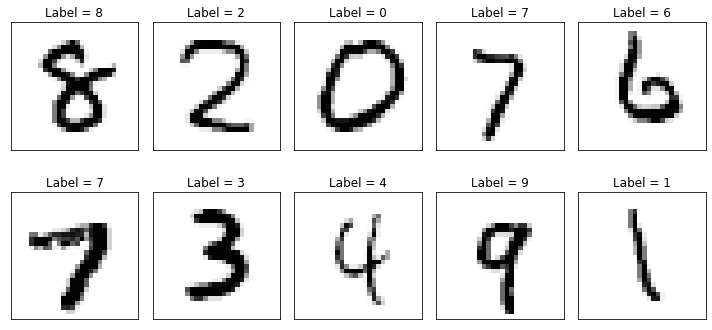

In [2]:
f, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i // 5, i % 5]
    index = np.random.randint(0, len(data))
    x, y = data[index]
    ax.imshow(x, cmap="Greys")
    ax.set_title("Label = {}".format(y))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Raw input data

- Raw data is loaded as image object
- Need as `torch.tensor` to use in `pytorch`

Type of x is: <class 'PIL.Image.Image'>


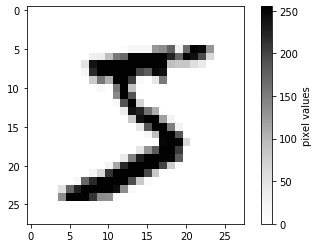

In [3]:
x, y = data[0]
print("Type of x is:", type(x))
plt.imshow(x, cmap="Greys")
cb = plt.colorbar(label = "pixel values")

## Transformed input data, pt. 1

- Use a transformation object to transform `PIL Image` to
  `pytorch` tensor.

Type of x_t:  <class 'torch.Tensor'>


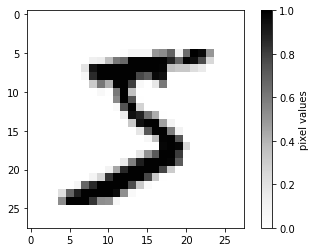

In [4]:
from torchvision.transforms import ToTensor
transform = ToTensor()
x_t = transform(x)
print("Type of x_t: ", type(x_t))

plt.imshow(x_t[0], cmap="Greys")
cb = plt.colorbar(label = "pixel values")

## Transformed input data, pt. 2  
  
- It's usually a good idea to normalize input data
- Use composition of two transformations to:
    - Transform image to tensor
    - Normalize pixel values


Shape of x_t:  torch.Size([1, 28, 28])


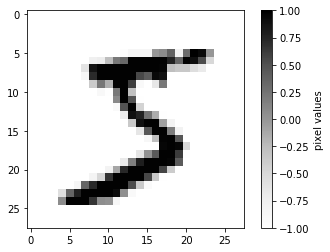

In [5]:
from torchvision.transforms import ToTensor, Compose, Normalize
transform = Compose([ToTensor(),
                     Normalize([0.5], [0.5])])
x_t = transform(x)
print("Shape of x_t: ", x_t.size())

plt.imshow(x_t[0], cmap="Greys")
cb = plt.colorbar(label = "pixel values")

## Apply transforms to dataset

- Provide transformations as `transform` argument to
  dataset constructor to apply them automatically to
  every image.

In [6]:
from torchvision.transforms import ToTensor, Compose, Normalize
transform = Compose([ToTensor(),
                     Normalize([0.5], [0.5])])
data = MNIST("./data",
             train=True,
             download=True,
             transform=transform)

## Data preparation
- Split dataset into training and validation part
- Create data loaders to group samples into batches

In [7]:
from torch.utils.data import DataLoader, random_split

# Split into training and validation part
n_train = int(0.8 * len(data))
n_val = len(data) - n_train
training_data, validation_data = random_split(data, [n_train, n_val])

# Organize data into batches
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True)

## The Dataloader class
- Groups a batch of input tensors into a single tensor with batch samples along
  first dimension
- Input image has shape $1 \times 28 \times 28$
    - 1 color channel (greyscale), 2 channels for horizontal and vertical image dimensions
- Batched data has shape $32 \times 1 \times 28 \times 28$

> **Note**: Convention in `pytorch` is *channels first*: Dimension corresponding to color comes before spatial dimensions

In [8]:
x_0, y_0 = next(iter(data))
x_1, y_1 = next(iter(training_loader))
print("Shape of x_0:", x_0.size())
print("Shape of x_1:", x_1.size())

Shape of x_0: torch.Size([1, 28, 28])
Shape of x_1: torch.Size([32, 1, 28, 28])


# Defining a neural network

## Typical approach

- Define a model class that inherits from `nn.Module`
- The `nn.Module` base class defines the general functionality that
  `pytorch` expects from a neural network
- Required:
   - Call to base class constructor: `super().__init__()`
   - `forward(...)` function that propagates input through network
     

In [9]:
class FullyConnected(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size):
        super().__init__()
        ...
        
    def forward(self, x):
        ...
        return y


## Typical approach

- Model class contains layers as attributes
- The `nn.Module` class automatically keeps track of
  the trainable parameters of the model

In [10]:
class FullyConnected(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size,  hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.flatten(1, -1)
        y = self.fc1(x)
        y = torch.relu(y)
        y = self.fc2(y)
        y = torch.relu(y)
        y = self.fc3(y)
        y = torch.relu(y)
        y = self.fc4(y)
        return y

## Typical approach

- To train a specific model you need to instantiate your model class

In [11]:
fc = FullyConnected(input_size=28 * 28,
                    hidden_size=128,
                    output_size=10)

# Training loop
- In `pytorch` you usually have an explicit training loop
- Below is basically a copy from the function provided in HW4a

In [12]:
def train_epoch(training_loader,
                validation_loader,
                model,
                loss,
                optimizer,
                device):
    """
    Train given model for one epoch and evaluate validation error.
    Args:
        training_loader: Iterable providing batched training data
        validation_loader: Iterable providing batched validation data
        loss: Loss function to minimize
        optimizer: Optimizer to use to optimizer loss.
        device: The torch device on which to run the calculations.
    """
    
    model.train()
    model.to(device)
    
    training_loss = 0.0
    n = len(training_loader)
    
    for i, (x, y) in enumerate(training_loader):
        
        # Set gradients to zero.
        optimizer.zero_grad()
        
        # Move input to device
        x = x.to(device)
        y = y.to(device)
        
        # Predict output, compute loss, perform optimizer step.
        y_pred = model(x)
        l = loss(y_pred, y)
        l.backward()
        optimizer.step()
        
        training_loss += l.item()
        print("Batch ({} / {}): Loss {:.2f}".format(i, n, l.item()), end="\r")
        
    training_loss /= n
        
    model.eval()
    validation_loss = 0.0
    n = len(validation_loader)
    
    for i, (x, y) in enumerate(validation_loader):
        # Move input to device
        x = x.to(device)
        y = y.to(device)
        
        # Predict output, compute loss, perform optimizer step.
        y_pred = model(x)
        l = loss(y_pred, y)
        
        validation_loss += l.item()
    validation_loss /= n
    
    model.to(torch.device("cpu"))
    
    return (training_loss, validation_loss)

        

# Choosing the loss function

- Note that we don't apply an activation function to the network outputs
- Instead of predicting probabilites directly, we predict **logits** (Unnormalized, log-probabilities)
  for each class
- This has numerical advantages (as explained in Sec. 6.2.2.1 and 6.2.2.2 of the [deep learning book](https://www.deeplearningbook.org/contents/mlp.html).)
- `pytorch` has specific loss functions that combine softmax or sigmoid and negative log-likelihood (NLL) loss

In [13]:
loss = nn.CrossEntropyLoss()

# Training the model

- This is now straight forward.

In [14]:
optimizer = torch.optim.Adam(fc.parameters())
device = torch.device("cpu")

for i in range(5):
    tl, vl = train_epoch(training_loader, validation_loader, fc, loss, optimizer, device)
    print("Epoch {}: Validation loss = {}".format(i + 1, vl))

Epoch 1: Validation loss = 0.19674349572261174
Epoch 2: Validation loss = 0.15995009420563777
Epoch 3: Validation loss = 0.13904228692377607
Epoch 4: Validation loss = 0.11740214523424705
Epoch 5: Validation loss = 0.14065055009784797


## CNN Example

### Another way of defining networks

- Networks with simple linear structure can also be defined using the `nn.Sequential` class
- Each transformation (convolution, activation function, pooling, flatten) defined by a layer object

In [15]:
cnn = nn.Sequential(nn.Conv2d(1, 32, 3),      # 26 x 26
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),       # 13 x 13
                    nn.Conv2d(32, 64, 3),     # 11 x 11
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),       # 5 x 5
                    nn.Flatten(1, -1),        # 25
                    nn.Linear(25 * 64, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

In [16]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters())
device = torch.device("cpu")

for i in range(3):
    tl, vl = train_epoch(training_loader, validation_loader, cnn, loss, optimizer, device)
    print("Epoch {}: Validation loss = {}".format(i + 1, vl))

Epoch 1: Validation loss = 0.05013138681960603
Epoch 2: Validation loss = 0.0387766053287002
Epoch 3: Validation loss = 0.03712521224746403


## Example results

- Brief look at some samples from test set.

In [17]:
from torchvision.transforms import ToTensor, Compose, Normalize
transform = Compose([ToTensor(),
                     Normalize([0.5], [0.5])])
data = MNIST("./data",
             train=False,
             download=True,
             transform=transform)

#### f, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i // 5, i % 5]
    
    index = np.random.randint(0, len(data))
    x, y = data[index]
    x = x.unsqueeze(dim=0)
    y_pred = torch.argmax(torch.softmax(cnn(x), -1))
    
    ax.imshow(x[0, 0], cmap="Greys")
    ax.set_title("Predicted = {}, \n True = {}".format(y_pred, y))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()